In [1]:

## MNIST

from fastai.vision.all import *
import numpy as np


##################################

## not the full MNIST. Just classes 7 and 3

path = untar_data(URLs.MNIST_SAMPLE)

print(   path.ls()   )


[Path('/home/rcalix/.fastai/data/mnist_sample/valid'), Path('/home/rcalix/.fastai/data/mnist_sample/labels.csv'), Path('/home/rcalix/.fastai/data/mnist_sample/train')]


In [2]:

print(  (path/'train').ls()   )


[Path('/home/rcalix/.fastai/data/mnist_sample/train/7'), Path('/home/rcalix/.fastai/data/mnist_sample/train/3')]


In [3]:

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

##print(  threes  )

im3_path = threes[1]

## uses PIL

im3 = Image.open(im3_path)

im3 


In [4]:

## LOOKING at the image as a numpy array and PyTorch tensor

print(    np.array(im3)[4:10, 4:10]     )


[[  0   0   0   0   0   0]
 [  0   0   0   0   0  29]
 [  0   0   0  48 166 224]
 [  0  93 244 249 253 187]
 [  0 107 253 253 230  48]
 [  0   3  20  20  15   0]]


In [5]:

tensor(im3)[4:10, 4:10]


tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [6]:

import pandas as pd

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


6131
6265


<AxesSubplot:>

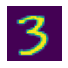

In [7]:

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

print( len(three_tensors)  )
print( len(seven_tensors)  )

show_image(three_tensors[1])


In [8]:

## make all images in each list into 1 cube (i.e. a tensor of d=3)
## type float and normalized

stacked_sevens = torch.stack(   seven_tensors   ).float()/255
stacked_threes = torch.stack(   three_tensors   ).float()/255

print(  stacked_threes.shape  )


torch.Size([6131, 28, 28])


In [9]:

## tensor rank (dimesionality of vector space)

print(  stacked_threes.ndim   )


3


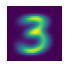

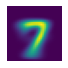

In [10]:

## Calculate the mean of all the image tensors
## For every pixel position, this will compute the average of that pixel
## over all images


## insight: it is darker where all images match and blurry where images do not match

mean3 = stacked_threes.mean(0)     ## 0 is on the zero axis 
show_image(mean3);

mean7 = stacked_sevens.mean(0)     ## 0 is on the zero axis 
show_image(mean7);


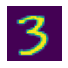

In [11]:

## Now we will measure the distance between one image and the mean of images for similarity 

## Get any image from the stack of images

a_3 = stacked_threes[1]    ## slice one out
show_image(a_3);


In [12]:

## calc L1-norm distance or CALC L2-norm (RMSE)

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

print("single 3 to mean 3")
print(dist_3_abs)
print(dist_3_sqr)


single 3 to mean 3
tensor(0.1114)
tensor(0.2021)


In [13]:

## not compare to the single 3 image to 7s mean

dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()

print('**********************')
print("single 3 to mean 7")
print(dist_7_abs)
print(dist_7_sqr)


**********************
single 3 to mean 7
tensor(0.1586)
tensor(0.3021)


In [14]:

## L1 and L2 are in torch 
## import torch.nn.functional as torch_f
## or
## fastai already has its own way of calling them

print(   F.l1_loss( a_3.float(), mean7)   )
print(   F.mse_loss(a_3, mean7).sqrt()    )


tensor(0.1586)
tensor(0.3021)


In [15]:

## Numpy Arrays and PyTorch tensors

data = [[1, 2, 3], [4, 5, 6]]
arr  = array(data)              ## fastai's way of incorporating numpy 
tns  = tensor(data)             ## fastai's way of incorporating torch

print(arr)
print(tns)


[[1 2 3]
 [4 5 6]]
tensor([[1, 2, 3],
        [4, 5, 6]])


In [16]:

print( type(arr) )
print( type(tns) )


<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [17]:

print(  tns[1]     )
print(  tns[:, 1]  )
print(  tns[1, 1:3])
print(    tns+1     )
print(    tns.type()     )
print(    tns*1.5        )


tensor([4, 5, 6])
tensor([2, 5])
tensor([5, 6])
tensor([[2, 3, 4],
        [5, 6, 7]])
torch.LongTensor
tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])


In [18]:

## validation set, create torch tensor and normalize it for 3 and 7

valid_3_tens = torch.stack(   [  tensor(Image.open(o))  for o in (path/'valid'/'3').ls()]   )
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack(   [  tensor(Image.open(o))  for o in (path/'valid'/'7').ls()]   )
valid_7_tens = valid_7_tens.float()/255

print(  valid_3_tens.shape  )
print(  valid_7_tens.shape  )


torch.Size([1010, 28, 28])
torch.Size([1028, 28, 28])


In [19]:

## function to get mean absolute error with the tensors 
## a-b  will use broadcasting when necessary 
## the (-1, -2) tells torch to calc mean only on the last 2 of the 3 axes (i.e. the 28x28 part )
## we take the differences first, then abs, and then mean

def mnist_distance(a, b):
    return (a-b).abs().mean((-1, -2))

print(    mnist_distance(a_3, mean3)    )


tensor(0.1114)


In [20]:

## now to calculate a metric for overall accuracy of a batch of images from the validation set (all 1010 at once)


## gives tensor of distances

valid_3_dist = mnist_distance(valid_3_tens, mean3)    
print(  valid_3_dist            )
print(  valid_3_dist.shape      )


tensor([0.1373, 0.1098, 0.1526,  ..., 0.1403, 0.1211, 0.1761])
torch.Size([1010])


In [21]:

def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)


print(    is_3(a_3)             )
print(    is_3(a_3).float()     )

print(    is_3(valid_3_tens)    )


tensor(True)
tensor(1.)
tensor([ True,  True, False,  ...,  True,  True,  True])


In [23]:

## now calculate accuracy of this model

accuracy_3s   =      is_3(valid_3_tens).float().mean()
accuracy_7s   = (1 - is_3(valid_7_tens).float()).mean()


print(   accuracy_3s       )
print(   accuracy_7s       )
print(   (accuracy_3s + accuracy_7s  )/2       )


tensor(0.9168)
tensor(0.9854)
tensor(0.9511)


In [26]:

## !pip install fastbook


In [29]:

## the training process and stochastic gradient descent
## THE PREVIOUS technique does not learn weights for a model
## so now we look at gradient descent so we can learn weights

## motivating SGD with the quadratic function


## from fastbook import *




In [35]:

def f(w):
    return w**2

x = np.linspace(-2.0, 2.0, num=9)
x



array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

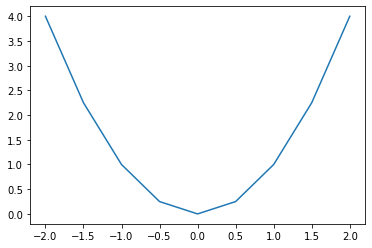

In [37]:

plt.plot(x, f(x))

## plot_function(f, 'w', 'cost determined by x**2')


In [38]:

## calculus
## getting the derivatives (e.g. the gradients)
## in deep learning, "gradient" usually means the value of a function's derivative at
## a paticular argument value (the weight)
## the focus is also on the variable (tensor(3.)), and not the function (e.g the cuadratic) 
## which is counter-intuitive

def f(w):
    return w**2

xt = tensor(3.).requires_grad_()

yt = f(xt)

print("notice the gradient association now of grad_fn")
print(yt)


notice the gradient association now of grad_fn
tensor(9., grad_fn=<PowBackward0>)


In [39]:

## now we tell pytorch to calc the gradients 

yt.backward()

## to view the gradient

print(  xt.grad    )

## in math, the function is x**2
## the derivative is   2x
## the variable x = 3
## the result is:   2x = 2(3) = 6


tensor(6.)


In [40]:

## now the same gradient scheme but with 3 weights instead of 
## just one, so a vector

xt = tensor([3., 4., 10.]).requires_grad_()
print(xt)

def f(x):
    return (x**2).sum()       ## sums all 3 values in vector

yt = f(xt)
print(    yt    )

yt.backward()
print(     xt.grad     )


tensor([ 3.,  4., 10.], requires_grad=True)
tensor(125., grad_fn=<SumBackward0>)
tensor([ 6.,  8., 20.])


In [41]:

## now we use xt.grad to adjust the weights
## w = w - (xt.grad * learning_rate)



## Repeat


In [64]:

def loss(y_pred, y_real):
    diff = y_pred - y_real
    return diff**2

wt = tensor(-2.5).requires_grad_()
xt = tensor(2.)

y_pred = wt * xt

y_real = tensor(1.0)

the_loss = loss(y_pred, y_real)

print("notice the gradient association now of grad_fn")
print(the_loss)


notice the gradient association now of grad_fn
tensor(36., grad_fn=<PowBackward0>)


In [65]:

the_loss.backward()

## to view the gradient

print(  wt.grad    )


tensor(-24.)


In [63]:

wt


tensor(-2.5000, requires_grad=True)

In [69]:

w = np.linspace(-4.0, 4.0, num=9)


In [75]:

def loss(y_pred, y_real):
    diff = y_pred - y_real
    return diff**2

losses_list = []
grads_list  = []

for item in w:
    
    wt = tensor(item).requires_grad_()
    xt = tensor(2.)
    y_pred = wt * xt
    y_real = tensor(1.0)
    the_loss = loss(y_pred, y_real)
    print("---------------------------")
    print(the_loss)
    losses_list.append( the_loss.detach().numpy() )
    
    the_loss.backward()
    print(  wt.grad    )
    grads_list.append(    wt.grad    )
    
    



---------------------------
tensor(81., grad_fn=<PowBackward0>)
tensor(-36.)
---------------------------
tensor(49., grad_fn=<PowBackward0>)
tensor(-28.)
---------------------------
tensor(25., grad_fn=<PowBackward0>)
tensor(-20.)
---------------------------
tensor(9., grad_fn=<PowBackward0>)
tensor(-12.)
---------------------------
tensor(1., grad_fn=<PowBackward0>)
tensor(-4.)
---------------------------
tensor(1., grad_fn=<PowBackward0>)
tensor(4.)
---------------------------
tensor(9., grad_fn=<PowBackward0>)
tensor(12.)
---------------------------
tensor(25., grad_fn=<PowBackward0>)
tensor(20.)
---------------------------
tensor(49., grad_fn=<PowBackward0>)
tensor(28.)


In [76]:

grads_list


[tensor(-36.),
 tensor(-28.),
 tensor(-20.),
 tensor(-12.),
 tensor(-4.),
 tensor(4.),
 tensor(12.),
 tensor(20.),
 tensor(28.)]

In [77]:

losses_list


[array(81., dtype=float32),
 array(49., dtype=float32),
 array(25., dtype=float32),
 array(9., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(9., dtype=float32),
 array(25., dtype=float32),
 array(49., dtype=float32)]

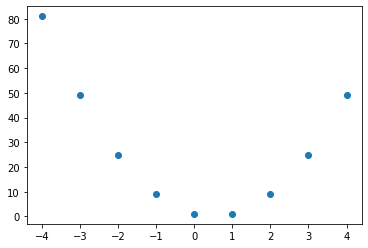

In [78]:

plt.scatter(w, losses_list)


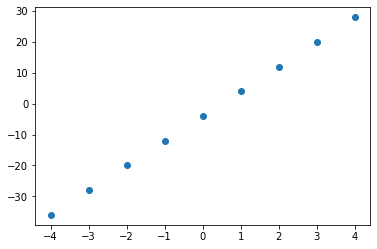

In [79]:

plt.scatter(w, grads_list)
